In [1]:
!pip install cleantext

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")

print("Path to dataset files:", path)

100%|██████████| 54.4M/54.4M [00:03<00:00, 17.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9


In [3]:
path = kagglehub.dataset_download("anmolkumar/glove-embeddings")

print("Path to dataset files:", path)

100%|██████████| 844M/844M [00:39<00:00, 22.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anmolkumar/glove-embeddings/versions/1


In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from cleantext import clean_words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import trange
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.initializers import Constant
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_nlp
sns.set()

In [5]:
os.listdir("/root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9")

['test.csv',
 'train.csv',
 'training.1600000.processed.noemoticon.csv',
 'testdata.manual.2009.06.14.csv']

In [6]:
df_train = pd.read_csv("/root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9/train.csv", encoding = "latin-1")
df_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [7]:
df_train.shape

(27481, 10)

In [8]:
df_train.duplicated().sum()

np.int64(0)

In [9]:
df_train["sentiment"].value_counts()

,count
sentiment,
neutral,11118
positive,8582
negative,7781


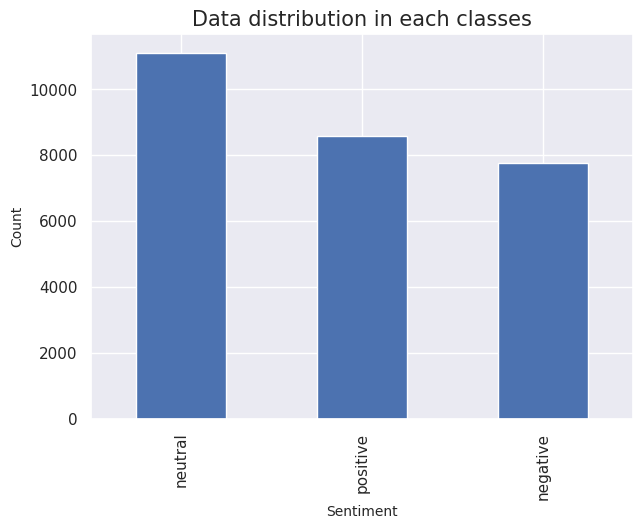

In [10]:
df_train["sentiment"].value_counts().plot(kind = "bar", figsize = (7, 5))
plt.title("Data distribution in each classes", fontsize = 15)
plt.xlabel("Sentiment", fontsize = 10)
plt.ylabel("Count", fontsize = 10)
plt.show()

In [11]:
df_train.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0
Time of Tweet,0
Age of User,0
Country,0
Population -2020,0
Land Area (Km²),0
Density (P/Km²),0


In [12]:
df_train.dropna(inplace = True)

In [13]:
try:
    nltk.download('averaged_perceptron_tagger_eng')
except:
    nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [15]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

In [16]:
def text_cleaning(text):
    words = clean_words(text, clean_all = False,
                        stemming = False,
                        lowercase = True,
                        extra_spaces = True,
                        stopwords = True,
                        numbers = True,
                        punct = True,
                        stp_lang = "english"
                       )
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return " ".join(words)

In [17]:
df_train["cleaned_text"] = df_train["text"].apply(text_cleaning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
df_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,id respond go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,bos bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,son couldnt put release already bought


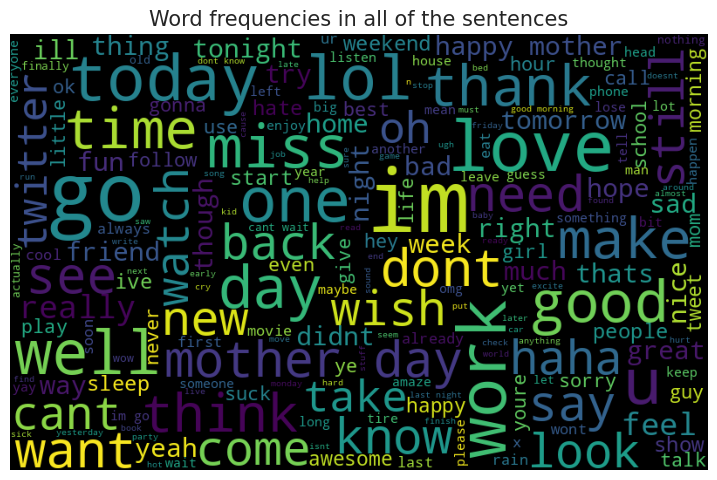

In [19]:
plt.figure(figsize = (9, 7))
all_sents = " ".join([sent for sent in df_train["cleaned_text"]])
word_c = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
plt.imshow(word_c)
plt.title("Word frequencies in all of the sentences", fontsize = 15)
plt.axis("off")
plt.show()

In [20]:
def word_cloud(data, sentiment):
    plt.figure(figsize = (9, 7))
    all_sents = " ".join([sent for sent in data["cleaned_text"][data["sentiment"] == sentiment]])
    word_c = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
    plt.imshow(word_c)
    plt.title(sentiment, fontsize = 15)
    plt.axis("off")
    plt.show()

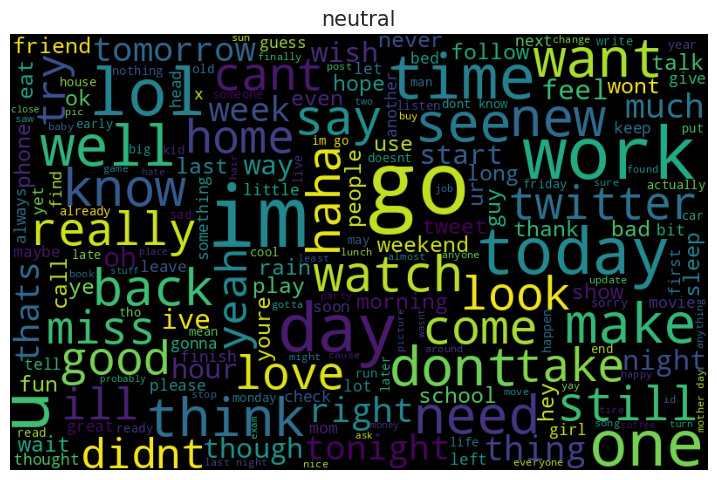

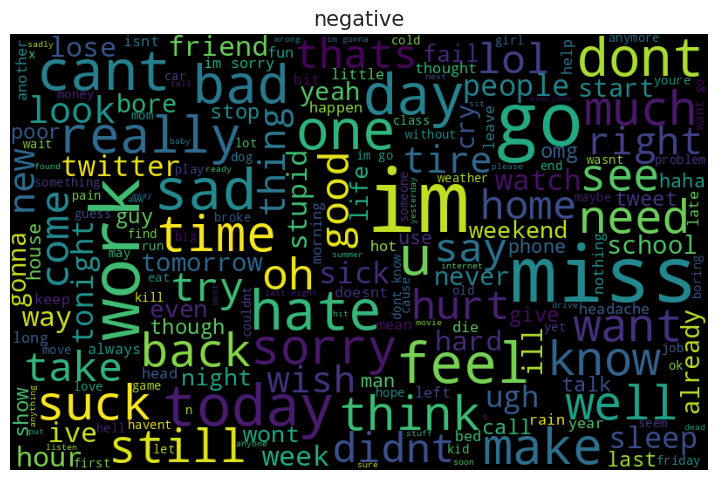

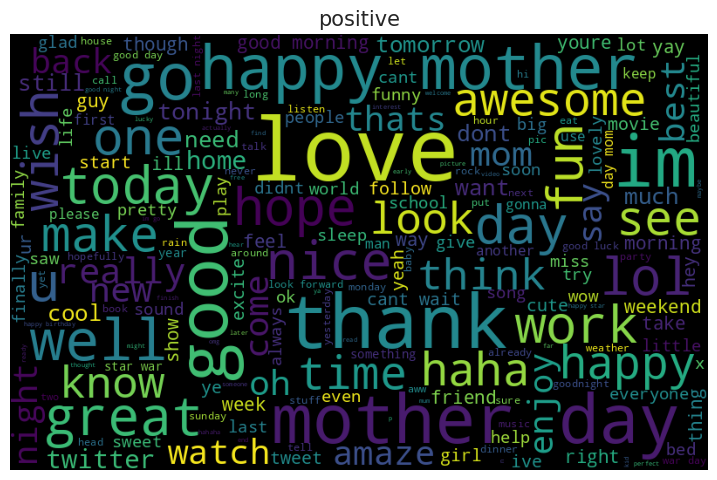

In [21]:
for sentiment in df_train["sentiment"].unique():
    word_cloud(df_train, sentiment)

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train["cleaned_text"])
seq = tokenizer.texts_to_sequences(df_train["cleaned_text"])

In [23]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = max([len(i) for i in seq])
print(f"Vocab size: {vocab_size}")
print(f"Max length of sequences: {maxlen}")

Vocab size: 24519
Max length of sequences: 23


In [24]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = "post")

In [25]:
encoder = LabelEncoder()
y_le = encoder.fit_transform(df_train["sentiment"])

In [26]:
smote = SMOTE(sampling_strategy = "not majority")

In [27]:
X, y = smote.fit_resample(pad_seq, y_le)

In [28]:
print(len(X))

33351


In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 101, stratify = y)

In [30]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")

Training set size: 26680
Validation set size: 6671


In [31]:
os.listdir("/root/.cache/kagglehub/datasets/anmolkumar/glove-embeddings/versions/1")

['glove.6B.300d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.50d.txt']

In [32]:
glove = open("/root/.cache/kagglehub/datasets/anmolkumar/glove-embeddings/versions/1/glove.6B.100d.txt")
embedding_matrix = dict()
for line in glove:
  record = line.split()
  word = record[0]
  vector = np.asarray(record[1:], dtype = "float32")
  embedding_matrix[word] = vector
glove.close()

In [33]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
  vec = embedding_matrix.get(word)
  if vec is not None:
    embedding_vectors[index] = vec

In [35]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41711   , -0.10176   ,  0.058147  , ..., -0.29444   ,
        -0.039114  ,  0.39534   ],
       [ 0.14432999,  0.43950999,  0.58323997, ...,  0.50133997,
         0.49535999,  0.49919999],
       ...,
       [-0.83793998,  0.18685   , -0.14855   , ...,  0.013608  ,
         0.85816002,  0.012751  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.76771998, -0.27450001,  0.053448  , ...,  0.43841001,
        -0.017146  ,  0.32326001]])

In [34]:
df_test = pd.read_csv("/root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9/test.csv", encoding = "latin-1")
df_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [36]:
df_test.shape

(4815, 9)

In [37]:
df_test.isnull().sum()

,0
textID,1281
text,1281
sentiment,1281
Time of Tweet,1281
Age of User,1281
Country,1281
Population -2020,1281
Land Area (Km²),1281
Density (P/Km²),1281


In [38]:
df_test.dropna(inplace = True)

In [39]:
df_test.shape

(3534, 9)

In [40]:
df_test.duplicated().sum()

np.int64(0)

In [41]:
df_test["cleaned_text"] = df_test["text"].apply(text_cleaning)

In [42]:
df_test["sentiment"].value_counts()

,count
sentiment,
neutral,1430
positive,1103
negative,1001


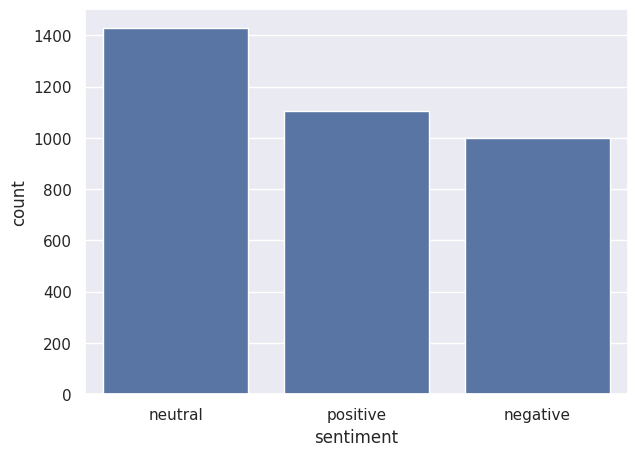

In [43]:
plt.figure(figsize = (7, 5))
sns.countplot(data = df_test, x = "sentiment")
plt.show()

In [44]:
test_seq = tokenizer.texts_to_sequences(df_test["cleaned_text"])

In [45]:
pad_test_seq = pad_sequences(test_seq, maxlen = maxlen, padding = "post")

In [46]:
y_test_le = encoder.fit_transform(df_test["sentiment"])

In [47]:
X_test, y_test = pad_test_seq, y_test_le

In [48]:
class PreparingDataset(Dataset):
  def __init__(self, texts, labels):
    self.texts = texts
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    return self.texts[index], self.labels[index]

In [49]:
train_dataset = PreparingDataset(X_train, y_train)
test_dataset = PreparingDataset(X_test, y_test)
valid_dataset = PreparingDataset(X_valid, y_valid)

In [50]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, num_workers = 4)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False, num_workers = 4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [52]:
num_classes = df_train["sentiment"].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 3


In [53]:
def plot_results(train_accs, train_losses, valid_accs, valid_losses):
  fig, axes = plt.subplots(1, 2, figsize = (15, 5))
  xs = np.arange(1, len(train_accs) + 1, 1) # Added +1 to include the last epoch
  axes[0].plot(xs, train_accs, label = "Training Accuracy")
  axes[0].plot(xs, valid_accs, label =  "Validation Accuracy")
  axes[0].set_title("Training accuracy vs Validation accuracy", fontsize = 15)
  axes[0].set_xlabel("Epoch", fontsize = 10)
  axes[0].set_ylabel("Accuracy", fontsize = 10)
  axes[0].set_xticks(xs)
  axes[0].legend()

  axes[1].plot(xs, train_losses, label = "Training Loss")
  axes[1].plot(xs, valid_losses, label = "Validation Loss")
  axes[1].set_title("Training loss vs Validation loss", fontsize = 15)
  axes[1].set_xlabel("Epoch", fontsize = 10)
  axes[1].set_ylabel("Loss", fontsize = 10)
  axes[1].set_xticks(xs)
  axes[1].legend()

  plt.tight_layout()
  plt.show()

In [ ]:
def train_step(model, criterion, optimizer, dataloader, device = device):
  model.train()
  total_acc = 0
  total_loss = 0
  for x, y in dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    preds = model(x)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_acc += (preds.argmax(1) == y).type(torch.float).sum().item()
  return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [ ]:
def valid_step(model, criterion, dataloader, device = device):
  model.eval()
  total_acc = 0
  total_loss = 0
  with torch.no_grad():
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      preds = model(x)
      total_loss += criterion(preds, y).item()
      total_acc += (preds.argmax(1) == y).type(torch.float).sum().item()
  return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [ ]:
def train_model(model, n_epochs, optimizer, train_loader, valid_loader, patience = 2, device = device):
  train_accs, train_losses = [], []
  valid_accs, valid_losses = [], []
  patience_counter = 0
  best_loss = float("inf")
  scheduler = ReduceLROnPlateau(optimizer, patience = 2, factor = 0.5, mode = "min")
  criterion = nn.CrossEntropyLoss()
  pbar = trange(n_epochs)
  for epoch in pbar:
    train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device = device)
    valid_loss, valid_acc = valid_step(model, criterion, valid_loader, device = device)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    valid_accs.append(valid_acc)
    valid_losses.append(valid_loss)
    scheduler.step(valid_loss)
    if valid_loss < best_loss:
      best_loss = valid_loss
      patience_counter = 0
      torch.save(model.state_dict(), "best_model.pt")
    else:
      patience_counter += 1
      if patience_counter >= patience:
        model.load_state_dict(torch.load("best_model.pt"))
        break
    pbar.set_description(f"Train Acc: {train_acc:.3f} | Valid Acc: {valid_acc:.3f} | Train Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}")
  plot_results(train_accs, train_losses, valid_accs, valid_losses)
  return {"train_acc": train_acc, "train_loss": train_loss, "valid_acc": valid_acc, "valid_loss": valid_loss}

In [ ]:
class LSTMMODEL(nn.Module):
  def __init__(self, num_classes, vocab_size, embedding_dim, hidden_units, embedding_vectors):
    super(LSTMMODEL, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.copy_(torch.tensor(embedding_vectors, dtype = torch.float32))

    self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first = True, bidirectional = True)
    self.dropout = nn.Dropout(0.6)
    self.fc = nn.Linear(hidden_units * 2, num_classes)

  def forward(self, x):
    x = self.embedding(x)
    x, (h_n, c_n) = self.lstm(x)
    x = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim = 1)
    x = self.dropout(x)
    x = self.fc(x)
    return x

Train Acc: 71.972 | Valid Acc: 64.458 | Train Loss: 0.671 | Valid Loss: 0.836:  15%|█▌        | 3/20 [00:15<01:27,  5.14s/it]


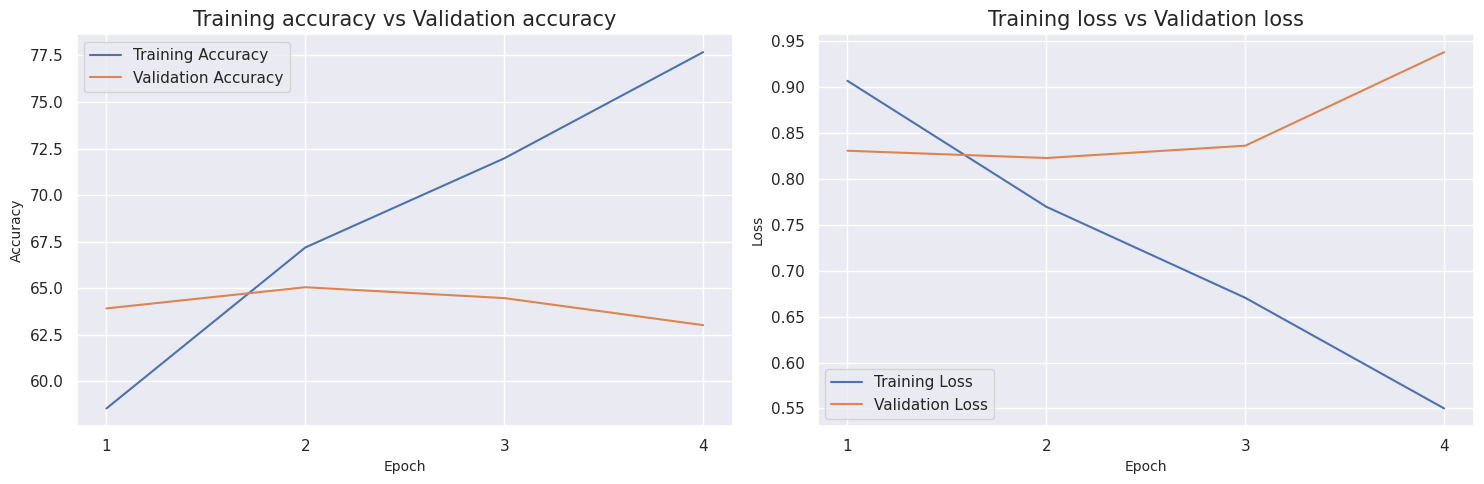

In [ ]:
model = LSTMMODEL(num_classes = num_classes, vocab_size = vocab_size, embedding_dim = 100, hidden_units = 256, embedding_vectors = embedding_vectors).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, valid_loader, device = device)

In [89]:
def cm(t_label, p_label):
  plt.figure(figsize = (7, 5))
  sns.heatmap(confusion_matrix(t_label, p_label), annot = True, cbar = True, square = True, annot_kws = {"size": 15}, fmt = 'd', cmap = "Blues")
  plt.title("Confuision Matrix", fontsize = 15)
  plt.xlabel("Predicted", fontsize = 10)
  plt.ylabel("Truth", fontsize = 10)
  plt.show()

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1001
           1       0.70      0.67      0.68      1430
           2       0.74      0.80      0.77      1103

    accuracy                           0.72      3534
   macro avg       0.72      0.72      0.72      3534
weighted avg       0.72      0.72      0.72      3534



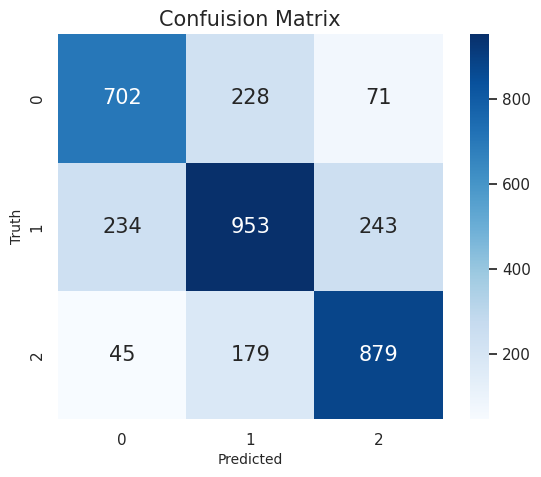

In [ ]:
model.eval()
total_loss = 0
total_acc = 0
y_t = []
y_p = []
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
  for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    preds = model(x)
    total_loss += criterion(preds, y).item()
    total_acc += (preds.argmax(1) == y).type(torch.float).sum().item()
    y_t.extend(y.cpu().numpy())
    y_p.extend(preds.argmax(1).cpu().numpy())
test_loss = total_loss / len(test_loader)
test_acc = 100 * total_acc / len(test_loader.dataset)
print(classification_report(y_t, y_p))
cm(y_t, y_p)

In [ ]:
tf_model = Sequential()

In [ ]:
tf_model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
tf_model.add(Bidirectional(LSTM(256)))
tf_model.add(Dense(num_classes, activation = "softmax"))

In [ ]:
tf_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

In [ ]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 2)

In [ ]:
history = tf_model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 20, callbacks = [early_stopping])

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


834/834 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.5455 - loss: 0.9616 - val_accuracy: 0.6180 - val_loss: 0.8629
Epoch 2/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6346 - loss: 0.8334 - val_accuracy: 0.6383 - val_loss: 0.8355
Epoch 3/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6609 - loss: 0.7880 - val_accuracy: 0.6402 - val_loss: 0.8275
Epoch 4/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6832 - loss: 0.7345 - val_accuracy: 0.6396 - val_loss: 0.8194
Epoch 5/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7123 - loss: 0.6764 - val_accuracy: 0.6366 - val_loss: 0.8431
Epoch 6/20
834/834 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7567 - loss: 0.5888 - val_accuracy: 0.6278 - val_loss: 0.9020


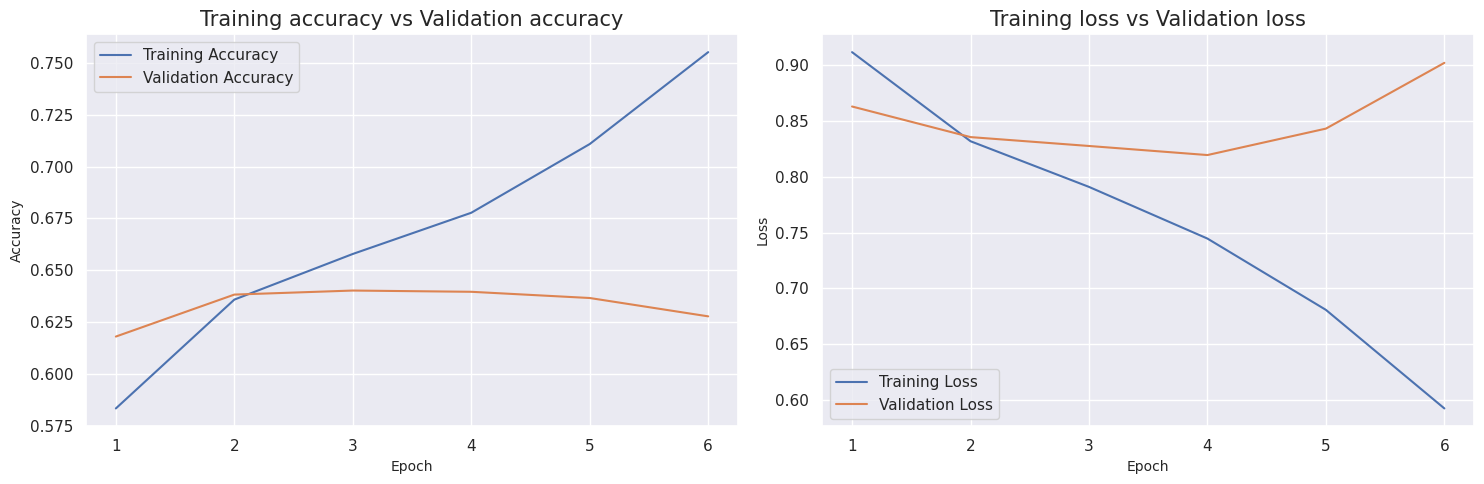

In [ ]:
plot_results(history.history["accuracy"], history.history["loss"], history.history["val_accuracy"], history.history["val_loss"])

In [70]:
df_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,id respond go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,bos bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,son couldnt put release already bought


In [71]:
df_train["sentiment"].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [72]:
df0 = df_train[df_train["sentiment"] == "negative"]
df1 = df_train[df_train["sentiment"] == "positive"].sample(df0.shape[0])
df2 = df_train[df_train["sentiment"] == "neutral"].sample(df0.shape[0])

In [73]:
df_b = pd.concat([df0, df1, df2])

In [75]:
df_b["y"] = encoder.fit_transform(df_b["sentiment"])

In [76]:
X_train, X_valid, y_train, y_valid = train_test_split(df_b["cleaned_text"], df_b["y"], test_size = 0.2, random_state = 101, stratify = df_b["y"])

In [77]:
df_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),cleaned_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day httptwitpiccomezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really excite precisely skyscrap...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,httptwitpiccomwp like


In [78]:
X_test = df_test["cleaned_text"]
y_test = encoder.fit_transform(df_test["sentiment"])

In [79]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [80]:
train_dataset = (train_data.shuffle(len(X_train)).batch(64).cache().prefetch(tf.data.AUTOTUNE))
test_dataset = (test_data.shuffle(len(X_test)).batch(64). cache().prefetch(tf.data.AUTOTUNE))
valid_dataset = (valid_data.shuffle(len(X_valid)).batch(64).cache().prefetch(tf.data.AUTOTUNE))

In [81]:
tokenizer = keras_nlp.models.BertTokenizer.from_preset("bert_small_en_uncased")

In [82]:
preprocessor = keras_nlp.models.BertPreprocessor(
    tokenizer,
    sequence_length = maxlen,
    truncate = "round_robin"
)

In [83]:
bert_model = keras_nlp.models.BertClassifier.from_preset(
    "bert_small_en_uncased",
    preprocessor = preprocessor,
    num_classes = num_classes,
    dropout = 0.2
)

In [84]:
bert_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

In [85]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 2)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 1, min_lr = 1e-6)

In [86]:
history = bert_model.fit(train_dataset, validation_data = valid_dataset, epochs = 10, callbacks = [early_stopping, reduce_lr])

Epoch 1/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 74s 154ms/step - accuracy: 0.5476 - loss: 0.9227 - val_accuracy: 0.7297 - val_loss: 0.6632 - learning_rate: 3.0000e-05
Epoch 2/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - accuracy: 0.7266 - loss: 0.6604 - val_accuracy: 0.7404 - val_loss: 0.6404 - learning_rate: 3.0000e-05
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - accuracy: 0.7700 - loss: 0.5755 - val_accuracy: 0.7417 - val_loss: 0.6536 - learning_rate: 3.0000e-05
Epoch 4/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - accuracy: 0.8047 - loss: 0.4986 - val_accuracy: 0.7415 - val_loss: 0.6676 - learning_rate: 1.5000e-05


In [87]:
bert_model.evaluate(test_dataset)

56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.7456 - loss: 0.6409


[0.6416648626327515, 0.7450481057167053]

In [88]:
y_p = bert_model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step


In [90]:
y_pred = y_p.argmax(1)

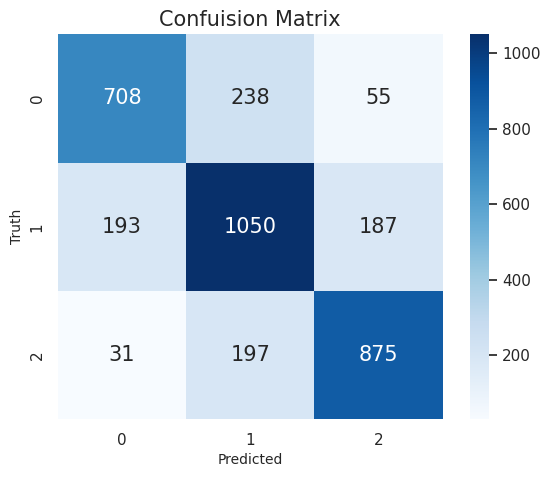

In [91]:
cm(y_test, y_pred)